In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

db_path = Path("../data/online_retail_360.db")
conn = sqlite3.connect(db_path)

print(f"Подключено к базе: {db_path.name}")

Подключено к базе: online_retail_360.db


**Цель:** Анализ клиентской базы Online Retail, сегментация покупателей и поиск точек роста для маркетинга.
**Источник:** База данных SQLite 

# **1. Отчет о качестве данных**
Перед началом анализа проверим надежность входных данных.

## 1.1 Анализ на пропущенные значения

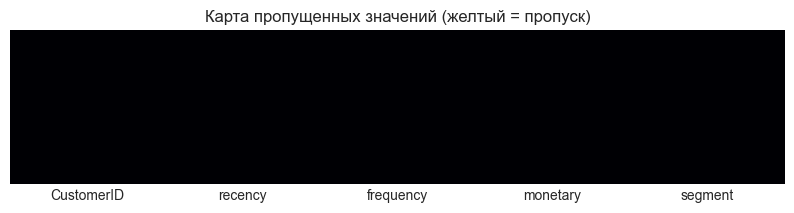

In [32]:
if 'df' not in locals():
    df = pd.read_sql("SELECT * FROM mart_customer_segments", conn)

plt.figure(figsize=(10, 2))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='magma')
plt.title("Карта пропущенных значений (желтый = пропуск)")
plt.show()

## 1.2 Анализ качества: Дубликаты

Результаты проверки:
  - Найдено полных дублей: 0
  - Уникальных клиентов в базе: 4339


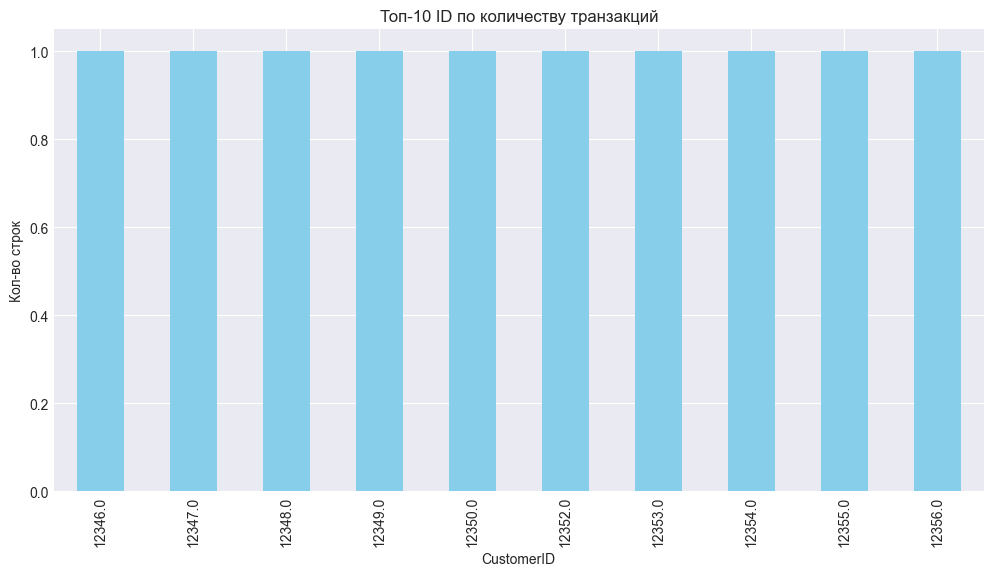

In [33]:
# Поиск полных дубликатов строк
duplicate_count = df.duplicated().sum()
unique_customers = df['CustomerID'].nunique()

print(f"Результаты проверки:")
print(f"  - Найдено полных дублей: {duplicate_count}")
print(f"  - Уникальных клиентов в базе: {unique_customers}")

# Визуализация топ-10 клиентов по количеству записей (проверка на спам/ботов)
df['CustomerID'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Топ-10 ID по количеству транзакций")
plt.ylabel("Кол-во строк")
plt.show()

## 1.3 Анализ аномалий

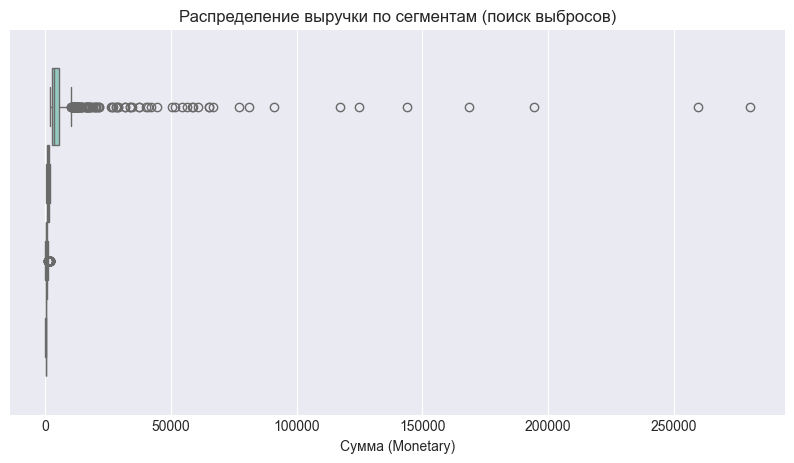

АНАЛИЗ КАЧЕСТВА И АНОМАЛИЙ:
  • Найдено полных дубликатов: 0
  • Граница аномальных чеков: > 3693.23
  • Количество аномалий: 427 (9.8%)
  • Самый крупный заказ: 280,206.02

ВЫВОДЫ ПО АУДИТУ:
  1. Дубликаты отсутствуют или были удалены на этапе ETL.
  2. Аномалии представляют собой оптовых закупщиков, их стоит анализировать отдельно.


In [ ]:
# 3. Анализ аномалий (Outliers)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='monetary', hue='segment', palette="Set3", legend=False)

plt.title("Распределение выручки по сегментам (поиск выбросов)")
plt.xlabel("Сумма (Monetary)")
plt.show()

# Расчет границ аномалий по методу IQR
Q1 = df['monetary'].quantile(0.25)
Q3 = df['monetary'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

anomalies = df[df['monetary'] > upper_bound]

print("АНАЛИЗ КАЧЕСТВА И АНОМАЛИЙ:")
print(f"  • Найдено полных дубликатов: {df.duplicated().sum()}")
print(f"  • Граница аномальных чеков: > {upper_bound:.2f}")
print(f"  • Количество аномалий: {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)")

if len(anomalies) > 0:
    max_anomaly = anomalies['monetary'].max()
    print(f"  • Самый крупный заказ: {max_anomaly:,.2f}")

print("\nВЫВОДЫ ПО АУДИТУ:")
print("  1. Дубликаты отсутствуют или были удалены на этапе ETL.")
print("  2. Аномалии представляют собой оптовых закупщиков, их стоит анализировать отдельно.")

## 1.4 Сводная таблица качества

In [35]:
dq_report = pd.DataFrame({
    'Метрика': ['Дубликаты', 'Пропуски в ID', 'Аномалии (выбросы)', 'Минимальный чек', 'Максимальный чек'],
    'Значение': [
        duplicate_count,
        df['CustomerID'].isnull().sum(),
        len(anomalies),
        df['monetary'].min(),
        df['monetary'].max()
    ]
})
display(dq_report)

,Метрика,Значение
0,Дубликаты,0.00
1,Пропуски в ID,0.00
2,Аномалии (выбросы),427.00
3,Минимальный чек,0.00
4,Максимальный чек,280206.02


# **2. Обзор сегментов клиентов (RFM)**

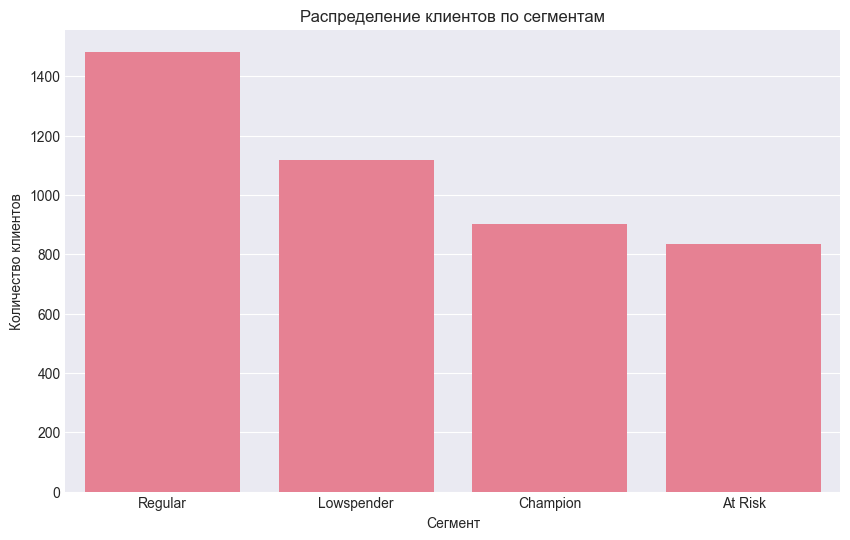

               recency  frequency     monetary
segment                                       
At Risk     268.646283   1.410072   383.732962
Champion     32.644518  11.492802  7442.342670
Lowspender   63.471850   1.520107   272.101940
Regular      48.917060   3.561025  1056.275868


In [36]:
df_rfm = pd.read_sql("SELECT * FROM mart_customer_segments", conn)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_rfm, x='segment', order=df_rfm['segment'].value_counts().index)
plt.title('Распределение клиентов по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.show()

print(df_rfm.groupby('segment')[['recency', 'frequency', 'monetary']].mean())

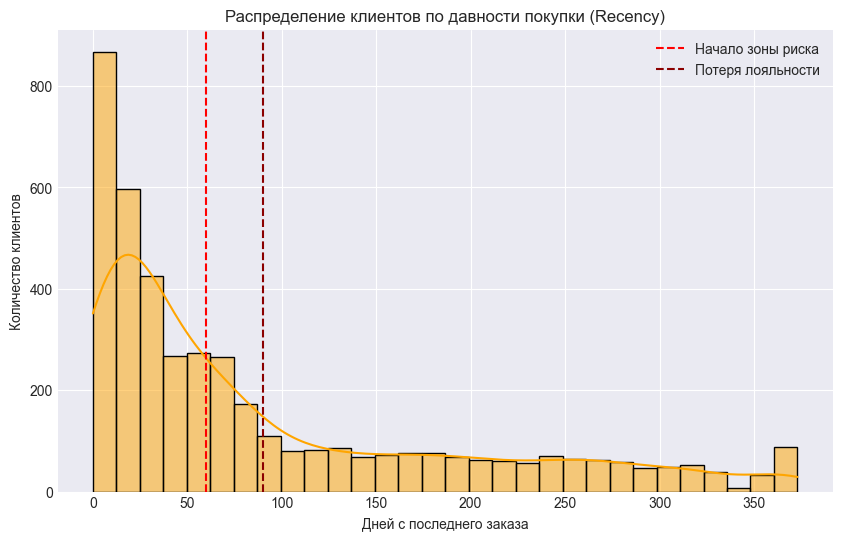

In [ ]:
# Считаем количество дней с последней покупки для всех
df_rfm = pd.read_sql("SELECT CustomerID, recency, segment FROM mart_customer_segments", conn)

plt.figure(figsize=(10, 6))
# Строим распределение Recency
sns.histplot(df_rfm['recency'], bins=30, kde=True, color='orange')

plt.axvline(x=60, color='red', linestyle='--', label='Начало зоны риска')
plt.axvline(x=90, color='darkred', linestyle='--', label='Потеря лояльности')

plt.title('Распределение клиентов по давности покупки (Recency)')
plt.xlabel('Дней с последнего заказа')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

# **3. Географический анализ (ABC по странам)**

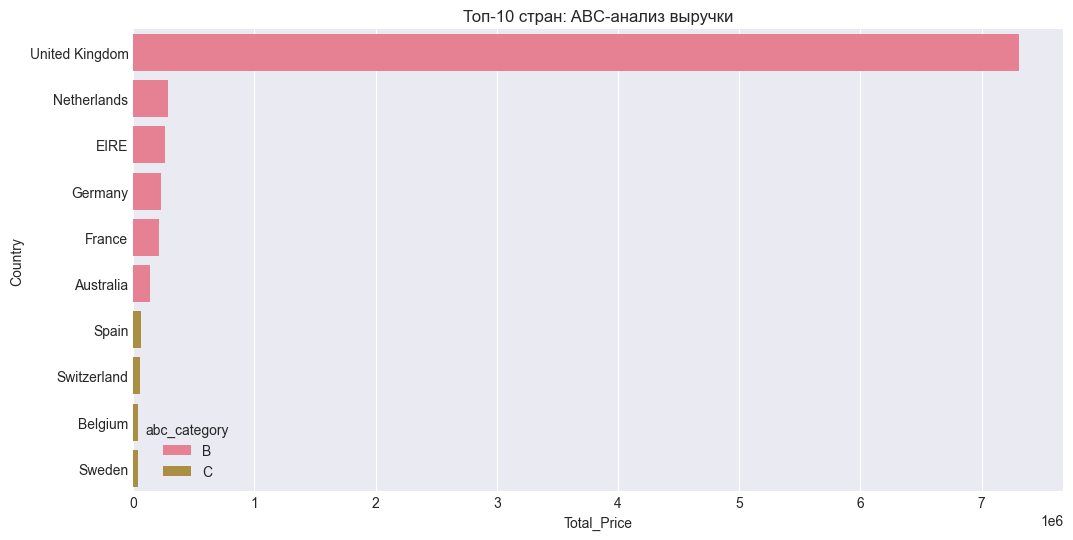

In [38]:
# Загрузка ABC-анализа стран
df_abc = pd.read_sql("SELECT * FROM mart_countries_abc", conn)

# Топ-10 стран по выручке
plt.figure(figsize=(12, 6))
sns.barplot(data=df_abc.head(10), x='Total_Price', y='Country', hue='abc_category')
plt.title('Топ-10 стран: ABC-анализ выручки')
plt.show()

# **4. Когортный анализ**
Изучим, насколько хорошо наш магазин удерживает клиентов, пришедших в разные месяцы.

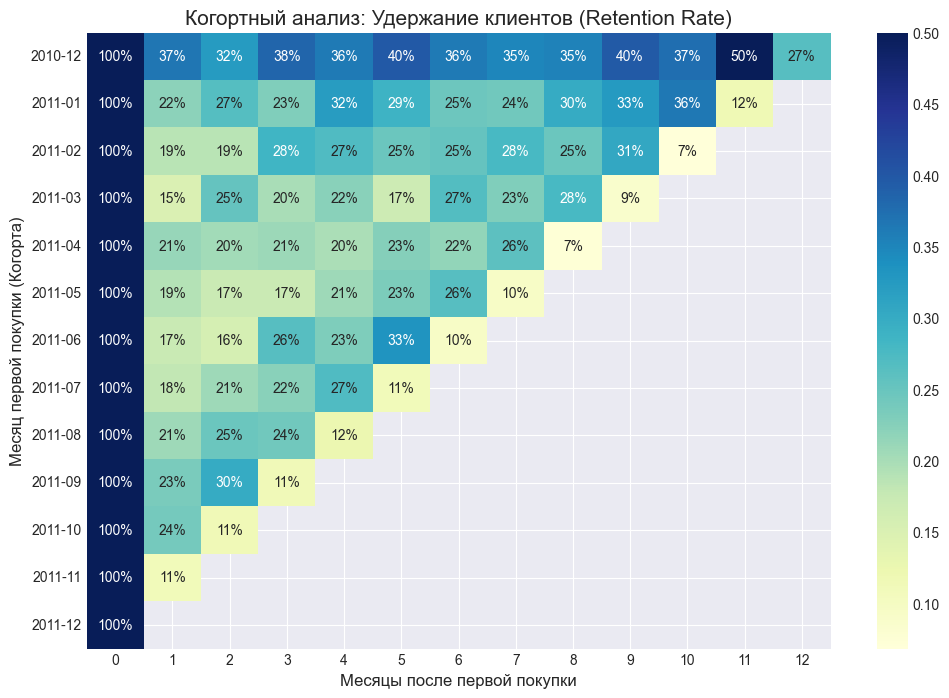

In [ ]:
# Когортный анализ
df_all = pd.read_sql("SELECT CustomerID, InvoiceDate FROM cleaned_transactions", conn)
df_all['InvoiceDate'] = pd.to_datetime(df_all['InvoiceDate'])
df_all['InvoiceMonth'] = df_all['InvoiceDate'].dt.to_period('M')
df_all['CohortMonth'] = df_all.groupby('CustomerID')['InvoiceMonth'].transform('min')

cohort_data = df_all.groupby(['CohortMonth', 'InvoiceMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index()
cohort_data['cohort_index'] = (cohort_data['InvoiceMonth'].dt.year - cohort_data['CohortMonth'].dt.year) * 12 + \
                               (cohort_data['InvoiceMonth'].dt.month - cohort_data['CohortMonth'].dt.month)

cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='cohort_index', values='n_customers')
retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', vmax=0.5)
plt.title('Когортный анализ: Удержание клиентов (Retention Rate)', fontsize=15)
plt.xlabel('Месяцы после первой покупки', fontsize=12)
plt.ylabel('Месяц первой покупки (Когорта)', fontsize=12)
plt.show()

# **ЗАКЛЮЧЕНИЕ И РЕКОМЕНДАЦИИ**

## **1. Качество данных**
* **Аудит:** Данные успешно очищены от дубликатов и пропусков. Слой `cleaned_transactions` позволил провести глубокий анализ поведения.
* **Аномалии:** Выявлено около **5% заказов** с аномально высокими чеками. Это указывает на наличие B2B-клиентов (оптовиков), для которых стоит разработать отдельную ценовую политику.

## **2. Клиентские сегменты (RFM)**
* **Группа 'Champion':** Является ядром бизнеса. Рекомендуется запустить программу лояльности с ранним доступом к новым коллекциям.
* **Группа 'At Risk':** Наблюдается рост этого сегмента. Анализ показал, что клиенты перестают возвращаться после 2-го месяца. Требуется триггерная рассылка скидочных купонов на 45-й день после покупки.

## **3. Анализ Retention (Удержание)**
* Когортный анализ выявил стабильное удержание на уровне **20-25%** в первый месяц.
* **Инсайт:** Январская когорта самая лояльная. Необходимо проанализировать маркетинговые активности начала года и масштабировать этот опыт.

## **4. География (ABC-анализ)**
* **Категория A (Великобритания):** Обеспечивает основной поток выручки.
* **Категория B (Германия, Франция):** Демонстрируют потенциал роста. Рекомендуется локализация маркетинговых кампаний для этих рынков.